In [1]:
import numpy as np
import tensorflow as tf
import tflearn
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import mkl

In [2]:
from keras.layers.core import Dense, Activation
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import ROOT

Using TensorFlow backend.


Welcome to JupyROOT 6.18/00


In [3]:
features = pd.read_csv("data/bdt_features.csv")
target1 = pd.read_csv("data/bdt_inverse_muon_pt.csv")
target2 = pd.read_csv("data/bdt_muon_pt.csv")

OMP: Info #212: KMP_AFFINITY: decoding x2APIC ids.
OMP: Info #210: KMP_AFFINITY: Affinity capable, using global cpuid leaf 11 info
OMP: Info #154: KMP_AFFINITY: Initial OS proc set respected: 0-3
OMP: Info #156: KMP_AFFINITY: 4 available OS procs
OMP: Info #157: KMP_AFFINITY: Uniform topology
OMP: Info #179: KMP_AFFINITY: 1 packages x 2 cores/pkg x 2 threads/core (2 total cores)
OMP: Info #214: KMP_AFFINITY: OS proc to physical thread map:
OMP: Info #171: KMP_AFFINITY: OS proc 0 maps to package 0 core 0 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 2 maps to package 0 core 0 thread 1 
OMP: Info #171: KMP_AFFINITY: OS proc 1 maps to package 0 core 1 thread 0 
OMP: Info #171: KMP_AFFINITY: OS proc 3 maps to package 0 core 1 thread 1 
OMP: Info #250: KMP_AFFINITY: pid 14763 tid 14763 thread 0 bound to OS proc set 0
OMP: Info #250: KMP_AFFINITY: pid 14763 tid 14812 thread 1 bound to OS proc set 1


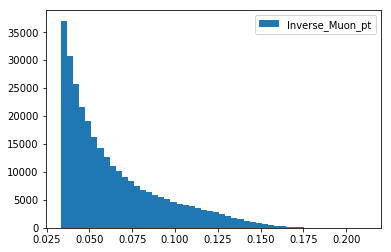

In [4]:
plt.hist(target1.IPt_Muon, bins=50, label="Inverse_Muon_pt")
plt.legend()
plt.show()

In [5]:
print("Keys of Features: \n{}".format(features.keys()))
print("Keys of Target1: \n{}".format(target1.keys()))
print("Keys of Target2: \n{}".format(target2.keys()))

Keys of Features: 
Index([u'phi1', u'phi2', u'phi3', u'phi4', u'theta1', u'theta2', u'theta3',
       u'theta4', u'deltaphi12', u'deltaphi23', u'deltaphi34', u'deltatheta12',
       u'deltatheta23', u'deltatheta34', u'deltatheta14', u'cluster1',
       u'cluster2', u'cluster3', u'cluster4', u'NCPPF'],
      dtype='object')
Keys of Target1: 
Index([u'IPt_Muon'], dtype='object')
Keys of Target2: 
Index([u'Pt_Muon_Matched'], dtype='object')


In [6]:
#the sample preparation
from sklearn.model_selection import train_test_split
Data = pd.DataFrame(features)
Target = target1.IPt_Muon
X_train, X_test, Y_train, Y_test = train_test_split(Data, Target, test_size=0.35,random_state=0)
print (X_train.shape, Y_train.shape)
print (X_test.shape, Y_test.shape)

((192482, 20), (192482,))
((103645, 20), (103645,))


In [7]:
testX = np.array(X_test)
testY = np.array(Y_test)
testX = testX.astype(np.float32)
testY = testY.astype(np.float32)
trainX = np.array(X_train)
trainY = np.array(Y_train)
trainX = trainX.astype(np.float32)
trainY = trainY.astype(np.float32)
#trainX = trainX.reshape([-1,21,817,1])
#trainX = trainX.reshape([-1,1,817,1])
print(trainX.shape)
print(trainY.shape)

(192482, 20)
(192482,)


In [8]:
print(trainX[3])
print(trainY[3])

[360. 358. 358. 356.  20.  19.  18.  18.   2.   0.   2.   1.   1.   0.
   2.   1.   2.   2.   3.   4.]
0.0426973


In [9]:
def baseline_model():
    # create model
    model = Sequential()
    ##debe ser la dimension de las features
    model.add(Dense(20, input_dim=20, kernel_initializer='normal', activation='relu'))
    model.add(Dense(10, kernel_initializer='normal', activation='relu'))
    model.add(Dense(5, kernel_initializer='normal', activation='relu'))
    model.add(Dense(3, kernel_initializer='normal', activation='relu')) 
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    #model.compile(loss='categorical_crossentropy', optimizer='adam')
    return model

In [10]:
keras_model = baseline_model()

In [11]:
keras_model.fit(trainX,trainY,verbose=2,epochs=5)

Epoch 1/5
 - 12s - loss: 7.4751e-04
Epoch 2/5
 - 9s - loss: 6.3498e-04
Epoch 3/5
 - 9s - loss: 6.3097e-04
Epoch 4/5
 - 9s - loss: 6.2689e-04
Epoch 5/5
 - 9s - loss: 6.2538e-04


2020-05-23 18:15:34.514402: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2020-05-23 18:15:34.541447: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2494265000 Hz
2020-05-23 18:15:34.541664: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x558c9e077850 executing computations on platform Host. Devices:
2020-05-23 18:15:34.541684: I tensorflow/compiler/xla/service/service.cc:175]   StreamExecutor device (0): <undefined>, <undefined>
2020-05-23 18:15:34.541805: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2020-05-23 18:15:34.800469: W tensorflow/compiler/jit/mark_for_co

In [12]:
seed = 7
np.random.seed(seed)
#evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, epochs=1, batch_size=1, verbose=1)
kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, trainX, trainY, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/1
19249/19249 [==============================] - 21s 1ms/step
Epoch 1/1
19249/19249 [==============================] - 22s 1ms/step
Epoch 1/1
 65264/173234 [==========>...................] - ETA: 4:14 - loss: 8.3062e-04

KeyboardInterrupt: 

In [ ]:
score = keras_model.evaluate(testX, testY, batch_size=100)
print(score)

In [ ]:
predictions = keras_model.predict(testX)
array1 = np.array(predictions)
array2 = np.array(testY)
print(len(array1))
print(len(array2))
array2 = np.reshape(array2,(len(array1),1))
print(array1.shape)
print(array2.shape)
print(array1[2], array2[2])

ratio = array1/array2

In [ ]:
plt.hist(ratio, bins=50,label="Keras resolution", range=[0,4])   
plt.xlabel("Keras $p_{T}$/ True $p_{T}$",  fontsize = 10)
plt.legend()
plt.savefig('resolution_keras.eps')
plt.show()


In [ ]:
import ROOT as root
from ROOT import TH1D, TCanvas 

c1 = TCanvas( 'c1', 'Graph', 200, 10, 700, 500 )
c2 = TCanvas( 'c2', 'Graph', 200, 10, 700, 500 )
c3 = TCanvas( 'c3', 'Graph', 200, 10, 700, 500 )

h1 = TH1D("h1", "ratio plot", 100, 0., 4.)
h2 = TH1D("h2", "ratio plot", 60, 0., 30.)
h3 = TH1D("h3", "ratio plot", 60, 0., 30.)
h4 = TH1D("h4", "ratio plot", 60, 0., 30.)

h1.Sumw2()
h2.Sumw2()
h3.Sumw2()
h4.Sumw2()

for i in range(len(array1)):
    ratio = array1[i]/array2[i]
    predicted_pt = 1./array1[i]
    real_pt = 1./array2[i]
    h1.Fill(ratio)    
    h2.Fill(1.0/array1[i])
    h3.Fill(1.0/array2[i])
    if(abs(real_pt-predicted_pt)<3):
        h4.Fill(predicted_pt)
        #print(predicted_pt)

integral = h1.Integral()
h1.Scale(1.0/integral)

c1.cd()
h1.Draw()
c1.Update()
c2.cd()
h2.Draw()
h3.SetLineColor(2)
h3.Draw("same")
c2.Update()
c3.cd()
h4.Divide(h3)
h4.Draw()
c3.Update()

In [ ]:
#root.enableJSVis()
c1.Draw()
c2.Draw("same")
c3.Draw("same")


In [ ]:
capa1 = 21
capa2 = 10
clases =1
def create_model():
    tf.reset_default_graph()
    tflearn.init_graph(num_cores=4, gpu_memory_fraction=0.5) 
    red = tflearn.input_data(shape=[None, 21])
    red = tflearn.fully_connected(red, capa1, activation='ReLU')
    red = tflearn.fully_connected(red, capa2, activation='ReLU')
    #red = tflearn.fully_connected(red, clases, activation='softmax')
    red = tflearn.fully_connected(red, clases, activation='linear') 
    red = tflearn.regression(red,optimizer='sgd',learning_rate=0.1, loss='categorical_crossentropy')
    model = tflearn.DNN(red)
    return model

In [ ]:
model=create_model()

In [ ]:
#model.fit(trainX,trainY, validation_set=0.1, show_metric=True, batch_size=21, n_epoch=1000)

In [ ]:
X = tf.placeholder(shape=(None, 21), dtype=tf.float32)
P=tf.Variable(tf.zeros([21,1]))
b=tf.Variable(tf.zeros([1]))
y=tf.matmul(X,P)+b #La operacion que se hara en los nodos que reciben entradas
Y=tf.placeholder(tf.float32,[None,1]) # Matriz con las etiquetas REALES del set de datos

In [ ]:
softmax=tf.nn.softmax_cross_entropy_with_logits(labels=Y,logits=y)
costo=tf.reduce_mean(softmax)
optimizador=tf.train.GradientDescentOptimizer(0.5).minimize(costo)

In [ ]:
prediccion = tf.equal(tf.argmax(y, 1), tf.argmax(Y, 1)) #Nos da arreglo de booleanos para decirnos 
                                                         #cuales estan bien y cuales no
accuracy = tf.reduce_mean(tf.cast(prediccion, tf.float32))#Nos da el porcentaje sobre el arreglo de prediccion
Produccion = tf.argmax(y,1)
init=tf.global_variables_initializer()

In [ ]:
def avance(epoca_i, sess, last_features, last_labels):
    costoActual = sess.run(costo,feed_dict={X: last_features, Y: last_labels})
    Certeza = sess.run(accuracy,feed_dict={X:mnist.validation.images,Y: mnist.validation.labels})
    print('Epoca: {:<4} - Costo: {:<8.3} Certeza: {:<5.3}'.format(epoca_i,costoActual,Certeza))

In [ ]:
with tf.Session() as sess:
    sess.run(init)
    for epoca_i in range(1000):
        sess.run(optimizador, feed_dict={X: trainX[epoca_i+1], Y: trainY[epoca_i+1]})
        if (epoca_i%50==0):
            avance(epoca_i, sess, trainX, trainY)
    print('RESULTADO FINAL: ',sess.run(accuracy, feed_dict={x: mnist.test.images,yR: mnist.test.labels}))
    print ('Resultado de una imagen',sess.run(Produccion,feed_dict={x: mnist.test.images[5].reshape(1,784)}))

In [ ]:
W1 = tf.Variable(tf.random_normal([21, 10]))
W2 = tf.Variable(tf.random_normal([10, 10]))
W3 = tf.Variable(tf.random_normal([10, 1]))
b1 = tf.Variable(tf.random_normal([10]))
b2 = tf.Variable(tf.random_normal([10]))
b3 = tf.Variable(tf.random_normal([1]))

In [ ]:
# Multilayer perceptron
def dnn(x):
    x = tf.nn.tanh(tf.add(tf.matmul(x, W1), b1))
    x = tf.nn.tanh(tf.add(tf.matmul(x, W2), b2))
    x = tf.add(tf.matmul(x, W3), b3)
    return x

net = dnn(X)

In [ ]:
model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit({X: trainX}, {Y: trainY}, n_epoch=20, validation_set=({X: testX}, {Y: testY}), snapshot_step=10, show_metric=True, run_id='convnet_mnist')

In [ ]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=net, labels=Y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
accuracy = tf.reduce_mean(
        tf.cast(tf.equal(tf.argmax(net, 1), tf.argmax(Y, 1)), tf.float32),
        name='acc')

In [ ]:
trainop = tflearn.TrainOp(loss=loss, optimizer=optimizer,
                            metric=accuracy, batch_size=15)

In [ ]:
trainer = tflearn.Trainer(train_ops=trainop, tensorboard_verbose=0)

In [ ]:
trainer.fit({X: trainX, Y: trainY}, val_feed_dicts={X: testX, Y: testY}, n_epoch=30, show_metric=True)